# Implémenter un réseau de neurones sur python

Si vous avez des questions: claire.theobald@univ-lorraine.fr

On importe tout d'abord des libraires python utiles: scikit-learn, tensorflow et matplotlib.

Pour installer les librairies sur votre machine:`pip install tensorflow scikit-learn matplotlib` ou avec conda (seulement si vous avez conda installé): `conda install -c conda-forge tensorflow scikit-learn matplotlib`

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

matplotlib est une librairie python qui permet le tracé et l'affichage de graphes.

scikit-learn (sklearn) quant à elle est une librairie d'outils de traitement des données et de machine learning. On va importer datasets (qui permet de charger des jeux de données), et d'autres outils de prétraitement des données.

Enfin, Tensorflow est une libraire spécialisée dans le machine learning, on va utiliser plus précisément keras qui va nous permettre de construire et d'entraîner des réseaux de neurones. Je vais vous montrer Tensorflow, car c'est une libraire très connue et maintenue en grande partie par Google (même si elle reste open source), mais sachez qu'il existe d'autres librairies pour construire des réseaux de neurones ! Entre autres: pytorch, pyspark... Vous êtes libres de choisir votre propre libraire si vous en avez envie mais ce document va se restreindre à Tensorflow.

Si vous avez une erreur lors de l'importation de tensorflow (et plus tard pour la compilation du modèle) vous disant que vous n'avez pas de GPU (carte graphique) dans votre ordinateur, vous pouvez l'ignorer. En effet, entraîner un réseau de neurones demande beaucoup de puissance de calcul et les GPU sont fréquemment utilisés de par leur puissance brute de calcul parallèle. Néanmoins nous allons jouer avec des petits jeux de données et le fait de ne pas utiliser de GPU ne va pas être très handicapant.

# Prétraitement

Nous allons charger le jeu de données Iris. Ce jeu contient 150 données possédant 4 attributs et 3 classes distinctes. Il y a 50 données par classe.

Le but de ce problème est de prédire l'espèce d'une plante Iris (3 espèces possibles) à partir de la longueur et la largeur de ses pétales et sépales (4 attributs).

In [2]:
iris = datasets.load_iris()

Récupérons les données et les classes respectivement:

In [3]:
X = iris.data
Y = iris.target

Regardons de plus près le format du jeu de données:

In [4]:
print(X.shape)
print(Y.shape)

(150, 4)
(150,)


Comme nous pouvons le constater, le jeu de données possède 4 attributs comme prévu. Cependant, il semble que le vecteur de classes soit unidimensionnel.

Etant donné que nous avons 3 classes différentes, l'idéal serait d'avoir 3 neurones dans la sortie du réseau de neurones. Il faut donc vectoriser $Y$ en utilisant un one-hot encoder.

In [5]:
Y = Y.reshape(-1,1) # Reshape to use the one hot encoder: it needs to be two dimensional
print(Y.shape)
enc = OneHotEncoder() # One hot encoder to vectorize the classes
Y = enc.fit_transform(Y).toarray()
print("Mapped output classes:")
print(enc.categories_)
print("New label shape:")
print(Y.shape)

(150, 1)
Mapped output classes:
[array([0, 1, 2])]
New label shape:
(150, 3)


L'encodeur a transformé $Y$ en une liste de vecteurs tel que tous les coefficients sont nuls sauf un qui vaut 1. "enc.categories_" montre la liste des classes avant transformation: $0,1$ or $2$. L'encodeur a attribué à ces classes les vecteurs $(1,0,0)$, $(0,1,0)$ et $(0,0,1)$ respectivement.

Cela va donc nous aider a construire un réseau de neurones avec 3 neurones en sortie: le premier va s'activer pour la classe $0$, le second pour la classe $1$ et le dernier pour la classe $2$.

Le vecteur "one-hot" peut être interpreté comme une distribution de probabilités: lorsque la valeur du label vaut $(1,0,0)$, cela veut dire que la probabilité de la classe $0$ est 1, et celle des deux autres est nulle.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1) # Split train and test set randomly with 75% and 25% proportion respectively
print(X_train.shape)
print(X_test.shape)

(112, 4)
(38, 4)


On divise le jeu de données pour l'entraînement et le test, avec comme proportions respectives 75% et 25%.

# Définir le modèle

In [7]:
def create_model():
    '''
    Create a fully connected neural network with one input layer, one hidden layer and one output layer with softmax activation.
    '''
    input_layer = keras.layers.Input(shape=(4,)) # Input layer
    h = keras.layers.Dense(128)(input_layer) # Hidden layer
    h = keras.layers.Dense(3, activation='softmax')(h) # Output layer
    model = keras.models.Model(inputs=input_layer, outputs=h)
    return model

Nous définissons désormais l'architecture du réseau de neurones. Le réseau ci-présent possède une couche d'entrée, une couche cachée et une couche de sortie.

La première couche est la couche d'entrée, qui a besoin d'une "shape" qui correspond au nombre de neurones en entrées, donc qui doit correspondre au nombre d'attributs de notre jeu de données. Ici nous avons 4 attributs donc 4 neurones en entrée.

La seconde couche est la couche cachée intermédiaire, qui possède 128 neurones.

La troisième couche est la couche de sortie, qui possède 3 neurones correspondant aux classes de sorties. La fonction d'activation "softmax" normalise les neurones $(x_{2,i})_{i=0}^2$ en sortie de telle sorte qu'ils représente une distribution de probabilité: $\forall x_{2,i}, 0 \leq x_{2,i} \leq 1$ and $\sum_i x_{2,i} = 1$.

Plus précisément, $$softmax(x)_i =\frac{e^{x_i}}{\sum_j e^{x_j}}$$

In [8]:
model = create_model() # We create the model
model.compile(optimizer=keras.optimizers.SGD(lr=1e-2), loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model: define optimizer, loss and eventual metrics

Une fois le modèle crée, il faut le compiler en définissant plusieurs paramètres:

Un optimiseur qui définit la méthode d'optimisation du réseau. Ici on choisit l'optimiseur SGD (pour Stochastic Gradient Descent), qui correspond à la descente de gradient par batch. L'adjectif "stochastique" réfère à un aspect aléatoire, non-déterministe. C'est parce qu'on calcule le gradient sur un "batch" (un "paquet") aléatoire de données à chaque fois et non pas le jeu de données complet. Cela permet un calcul approximatif mais plus rapide de l'algorithme. D'autres méthodes d'optimisation existent, telles que des méthodes qui calculent un learning rate de manière adaptive (Adam), mais ce n'est pas l'objectif de cet exemple...

L'argument "lr" correspond au learning rate, qui peut s'interpréter comme le pas dans la descente de gradient. Il s'agit du coefficient $\eta$ dans l'équation de mise à jour des poids: $w \leftarrow w - \eta \triangledown E[w]$. Un learning rate plus petit permet un apprentissage plus fin et précis mais également plus long.

Le paramètre "loss" définit la fonction d'erreur que le réseau va chercher à minimiser. Ici, on utilise la loss entropie croisée catégorique, définie de la manière suivante:

$$E(z)=-\sum_{i=0}^2 y_i \log(z_i)$$

Ou $z$ est la sortie du réseau (après softmax), et $y$ le vecteur one-hot du jeu de données que le réseau devrait prédire. Par exemple, si la vraie classe à prédire est $2$, $y=(0,0,1)$ et alors $E(z)=-\log(z_2)$ et donc le réseau va chercher à maximiser $z_2$, soit le neurone correspondant à la classe $2$. Comme on a normalisé les neurones en sortie, cela va correspondre à minimiser $z_0$ et $z_1$.

L'entropie croisée entre deux distributions $p$ et $q$ peut s'interpréter comme un degré d'incertitude entre les deux distributions: plus elle est élevée, moins il y a d'information commune entre les deux distributions. Lorsqu'elle est minimale, les deux distributions sont identiques, c'est pourquoi la méthode d'optimisation de l'entropie croisée est souvent utilisée lorsqu'on veut faire correspondre deux distributions de probabilités comme c'est notre cas ici.

Le dernier paramètre, "metrics" permet d'ajouter des métriques à enregistrer pendant l'entraînement. Ici on a ajouté "accuracy" pour mesurer la précision de notre modèle durant son entraînement.

# Entraînement du modèle et résultats

Nous allons maintenant lancer l'entraînement du modèle. On définit d'abord les données et labels d'entraînement (X_train et Y_train).

Le "batch_size" correspond à la taille du paquet de données utilisé pour l'optimisation via SGD comme expliqué précédemment. Un batch size plus grand donne une meilleure approximation de l'optimisation mais rend les calculs plus complexes.

L'argument "epoch" correspond à la durée de l'entraînement. Une époque correspond au nombre d'optimisations nécessaires pour voir chaque donnée au moins une fois. Une interprétation possible est la suivante: à chaque fois, le réseau retire un "batch" de données sans remise, et optimise ses poids. Il continue ainsi jusqu'à ce que le jeu de données soit vide: cela correspond à une époque. Mettre 250 époques veut dire que l'algorithme se répète 250 fois. Le nombre d'itérations dans une époque est proportionnel au batch size: il y a 112 données dans le jeu d'entraînement (75% de 150), donc il y a $\frac{112}{16}=7$ itérations d'optimisation par époque.

In [9]:
model_history = model.fit(X_train,Y_train,
                          batch_size=16,
                          epochs=250,
                          validation_data=(X_test,Y_test))

Epoch 1/250
7/7 [==============================] - 1s 137ms/step - loss: 1.3029 - accuracy: 0.4029 - val_loss: 0.9907 - val_accuracy: 0.5789
Epoch 2/250
7/7 [==============================] - 0s 5ms/step - loss: 0.9555 - accuracy: 0.5187 - val_loss: 0.8759 - val_accuracy: 0.5789
Epoch 3/250
7/7 [==============================] - 0s 5ms/step - loss: 0.7860 - accuracy: 0.7266 - val_loss: 0.9044 - val_accuracy: 0.5789
Epoch 4/250
7/7 [==============================] - 0s 4ms/step - loss: 0.8422 - accuracy: 0.6204 - val_loss: 0.8341 - val_accuracy: 0.5789
Epoch 5/250
7/7 [==============================] - 0s 5ms/step - loss: 0.6971 - accuracy: 0.7064 - val_loss: 0.6597 - val_accuracy: 0.7105
Epoch 6/250
7/7 [==============================] - 0s 5ms/step - loss: 0.6542 - accuracy: 0.7584 - val_loss: 0.7385 - val_accuracy: 0.5789
Epoch 7/250
7/7 [==============================] - 0s 5ms/step - loss: 0.5699 - accuracy: 0.7704 - val_loss: 0.5892 - val_accuracy: 0.7632
Epoch 8/250
7/7 [========

7/7 [==============================] - 0s 4ms/step - loss: 0.2491 - accuracy: 0.9620 - val_loss: 0.3003 - val_accuracy: 0.9474
Epoch 60/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2866 - accuracy: 0.9400 - val_loss: 0.3248 - val_accuracy: 0.8947
Epoch 61/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2578 - accuracy: 0.9456 - val_loss: 0.3031 - val_accuracy: 0.9211
Epoch 62/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2641 - accuracy: 0.9470 - val_loss: 0.2900 - val_accuracy: 0.9474
Epoch 63/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2724 - accuracy: 0.9627 - val_loss: 0.2782 - val_accuracy: 0.9737
Epoch 64/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2444 - accuracy: 0.9678 - val_loss: 0.2729 - val_accuracy: 0.9474
Epoch 65/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2445 - accuracy: 0.9727 - val_loss: 0.2704 - val_accuracy: 0.9474
Epoch 66/250
7/7 [===============

7/7 [==============================] - 0s 5ms/step - loss: 0.1441 - accuracy: 0.9846 - val_loss: 0.1976 - val_accuracy: 0.9737
Epoch 118/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1485 - accuracy: 0.9872 - val_loss: 0.2040 - val_accuracy: 0.9737
Epoch 119/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1564 - accuracy: 0.9772 - val_loss: 0.2040 - val_accuracy: 0.9737
Epoch 120/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2011 - accuracy: 0.9502 - val_loss: 0.1982 - val_accuracy: 0.9737
Epoch 121/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9798 - val_loss: 0.2147 - val_accuracy: 0.9474
Epoch 122/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1460 - accuracy: 0.9714 - val_loss: 0.2109 - val_accuracy: 0.9474
Epoch 123/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1289 - accuracy: 0.9872 - val_loss: 0.1994 - val_accuracy: 0.9737
Epoch 124/250
7/7 [========

7/7 [==============================] - 0s 5ms/step - loss: 0.1288 - accuracy: 0.9667 - val_loss: 0.1555 - val_accuracy: 0.9737
Epoch 176/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1272 - accuracy: 0.9824 - val_loss: 0.1517 - val_accuracy: 0.9737
Epoch 177/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1184 - accuracy: 0.9746 - val_loss: 0.1584 - val_accuracy: 0.9737
Epoch 178/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1496 - accuracy: 0.9693 - val_loss: 0.1660 - val_accuracy: 0.9737
Epoch 179/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1137 - accuracy: 0.9821 - val_loss: 0.1742 - val_accuracy: 0.9474
Epoch 180/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1583 - accuracy: 0.9402 - val_loss: 0.1690 - val_accuracy: 0.9474
Epoch 181/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1108 - accuracy: 0.9740 - val_loss: 0.1556 - val_accuracy: 0.9737
Epoch 182/250
7/7 [========

7/7 [==============================] - 0s 5ms/step - loss: 0.1094 - accuracy: 0.9634 - val_loss: 0.1607 - val_accuracy: 0.9474
Epoch 234/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1196 - accuracy: 0.9759 - val_loss: 0.1616 - val_accuracy: 0.9474
Epoch 235/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1421 - accuracy: 0.9615 - val_loss: 0.1335 - val_accuracy: 0.9737
Epoch 236/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1040 - accuracy: 0.9628 - val_loss: 0.1266 - val_accuracy: 0.9737
Epoch 237/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1150 - accuracy: 0.9759 - val_loss: 0.1342 - val_accuracy: 0.9737
Epoch 238/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1228 - accuracy: 0.9700 - val_loss: 0.1457 - val_accuracy: 0.9737
Epoch 239/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1234 - accuracy: 0.9581 - val_loss: 0.1413 - val_accuracy: 0.9737
Epoch 240/250
7/7 [========

In [10]:
print("Final train accuracy is: "+str(model_history.history["accuracy"][-1]))
print("Final test accuracy is: "+str(model_history.history["val_accuracy"][-1]))

Final train accuracy is: 0.9732142686843872
Final test accuracy is: 0.9736841917037964


On voit que notre modèle se débrouille plutôt bien: on devrait obtenir entre 0.94 et 1 de précision sur le jeu d'entraînement et de validation ! Notez que si vous relancez l'entraînement plusieurs fois vous risquez d'avoir des résultats différents: c'est normal. Il y a plusieurs aspects aléatoires dans notre démarche: d'une part, les poids du réseau sont initialisés aléatoirement à chaque fois, donc les conditions initiales sont différentes à chaque fois. De plus, comme expliqué précédemment, l'algorithme d'optimisation SGD fait en sorte que les "batch" de données sont pris aléatoirement, ce qui fait que les poids ne sont jamais vraiment mis à jour de la même manière à chaque fois.

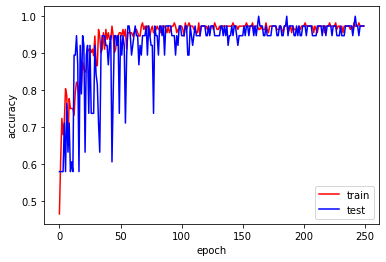

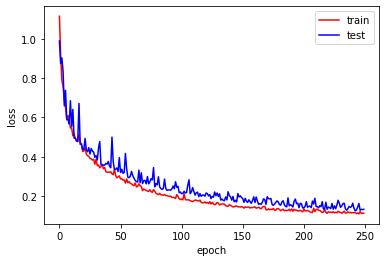

<Figure size 432x288 with 0 Axes>

In [11]:
t = range(250)

plt.plot(t,model_history.history["accuracy"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_accuracy"],'b', label='test', linewidth=1.5)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

plt.plot(t,model_history.history["loss"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_loss"],'b', label='test', linewidth=1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

On affiche ici la précision et la fonction de perte (loss) au cours de l'apprentissage, pour le jeu d'entraînement et de validation. Cela est utile pour observer l'évolution des performances au cours du temps, notamment à partir de quand on peut considérer que l'algorithme a convergé, ou s'il faut laisser plus d'époques ou mettre un learning rate plus ou moins élevé. Ici, on arrive rapidement à convergence en moins de 200 époques.

# Influence des paramètres

On peut maintenant réaliser l'expérience en changeant différents paramètres, par exemple en diminuant le learning rate:

Epoch 1/250
7/7 [==============================] - 0s 20ms/step - loss: 1.2455 - accuracy: 0.4032 - val_loss: 1.3061 - val_accuracy: 0.4474
Epoch 2/250
7/7 [==============================] - 0s 4ms/step - loss: 1.1909 - accuracy: 0.5054 - val_loss: 1.2984 - val_accuracy: 0.5789
Epoch 3/250
7/7 [==============================] - 0s 4ms/step - loss: 1.2740 - accuracy: 0.4660 - val_loss: 1.2916 - val_accuracy: 0.6053
Epoch 4/250
7/7 [==============================] - 0s 5ms/step - loss: 1.1907 - accuracy: 0.5873 - val_loss: 1.2854 - val_accuracy: 0.6053
Epoch 5/250
7/7 [==============================] - 0s 4ms/step - loss: 1.2144 - accuracy: 0.6055 - val_loss: 1.2798 - val_accuracy: 0.6053
Epoch 6/250
7/7 [==============================] - 0s 4ms/step - loss: 1.2815 - accuracy: 0.5663 - val_loss: 1.2747 - val_accuracy: 0.5263
Epoch 7/250
7/7 [==============================] - 0s 5ms/step - loss: 1.1537 - accuracy: 0.6304 - val_loss: 1.2700 - val_accuracy: 0.5000
Epoch 8/250
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 1.0767 - accuracy: 0.3577 - val_loss: 1.1521 - val_accuracy: 0.2368
Epoch 60/250
7/7 [==============================] - 0s 5ms/step - loss: 1.0422 - accuracy: 0.3789 - val_loss: 1.1502 - val_accuracy: 0.2368
Epoch 61/250
7/7 [==============================] - 0s 5ms/step - loss: 1.0250 - accuracy: 0.4105 - val_loss: 1.1482 - val_accuracy: 0.2368
Epoch 62/250
7/7 [==============================] - 0s 4ms/step - loss: 1.0549 - accuracy: 0.3643 - val_loss: 1.1464 - val_accuracy: 0.2368
Epoch 63/250
7/7 [==============================] - 0s 4ms/step - loss: 1.0021 - accuracy: 0.4396 - val_loss: 1.1444 - val_accuracy: 0.2368
Epoch 64/250
7/7 [==============================] - 0s 4ms/step - loss: 1.0203 - accuracy: 0.4070 - val_loss: 1.1426 - val_accuracy: 0.2368
Epoch 65/250
7/7 [==============================] - 0s 4ms/step - loss: 1.0258 - accuracy: 0.3896 - val_loss: 1.1407 - val_accuracy: 0.2368
Epoch 66/250
7/7 [===============

7/7 [==============================] - 0s 5ms/step - loss: 0.9782 - accuracy: 0.3406 - val_loss: 1.0496 - val_accuracy: 0.2368
Epoch 118/250
7/7 [==============================] - 0s 5ms/step - loss: 0.9773 - accuracy: 0.3453 - val_loss: 1.0480 - val_accuracy: 0.2368
Epoch 119/250
7/7 [==============================] - 0s 4ms/step - loss: 0.9522 - accuracy: 0.3885 - val_loss: 1.0464 - val_accuracy: 0.2368
Epoch 120/250
7/7 [==============================] - 0s 5ms/step - loss: 0.9651 - accuracy: 0.3544 - val_loss: 1.0448 - val_accuracy: 0.2368
Epoch 121/250
7/7 [==============================] - 0s 4ms/step - loss: 0.9339 - accuracy: 0.4112 - val_loss: 1.0431 - val_accuracy: 0.2368
Epoch 122/250
7/7 [==============================] - 0s 4ms/step - loss: 0.9683 - accuracy: 0.3245 - val_loss: 1.0415 - val_accuracy: 0.2368
Epoch 123/250
7/7 [==============================] - 0s 4ms/step - loss: 0.9358 - accuracy: 0.3859 - val_loss: 1.0399 - val_accuracy: 0.2368
Epoch 124/250
7/7 [========

7/7 [==============================] - 0s 5ms/step - loss: 0.8856 - accuracy: 0.4028 - val_loss: 0.9639 - val_accuracy: 0.2368
Epoch 176/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8658 - accuracy: 0.4392 - val_loss: 0.9626 - val_accuracy: 0.2368
Epoch 177/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8655 - accuracy: 0.4601 - val_loss: 0.9612 - val_accuracy: 0.2368
Epoch 178/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8742 - accuracy: 0.4089 - val_loss: 0.9599 - val_accuracy: 0.2368
Epoch 179/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8620 - accuracy: 0.4661 - val_loss: 0.9585 - val_accuracy: 0.2368
Epoch 180/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8741 - accuracy: 0.4341 - val_loss: 0.9572 - val_accuracy: 0.2368
Epoch 181/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8823 - accuracy: 0.4070 - val_loss: 0.9559 - val_accuracy: 0.2368
Epoch 182/250
7/7 [========

7/7 [==============================] - 0s 5ms/step - loss: 0.8116 - accuracy: 0.7191 - val_loss: 0.8940 - val_accuracy: 0.5789
Epoch 234/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8558 - accuracy: 0.6409 - val_loss: 0.8930 - val_accuracy: 0.5789
Epoch 235/250
7/7 [==============================] - 0s 4ms/step - loss: 0.8406 - accuracy: 0.6604 - val_loss: 0.8919 - val_accuracy: 0.5789
Epoch 236/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8327 - accuracy: 0.6939 - val_loss: 0.8908 - val_accuracy: 0.5789
Epoch 237/250
7/7 [==============================] - 0s 4ms/step - loss: 0.8197 - accuracy: 0.7064 - val_loss: 0.8898 - val_accuracy: 0.5789
Epoch 238/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8497 - accuracy: 0.6342 - val_loss: 0.8887 - val_accuracy: 0.5789
Epoch 239/250
7/7 [==============================] - 0s 4ms/step - loss: 0.8287 - accuracy: 0.6799 - val_loss: 0.8877 - val_accuracy: 0.5789
Epoch 240/250
7/7 [========

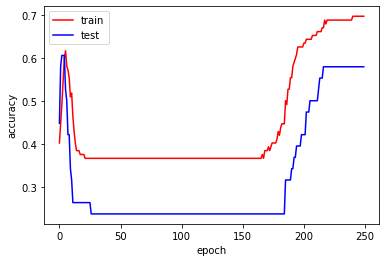

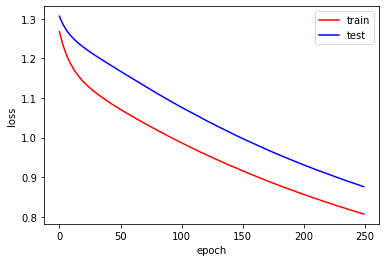

<Figure size 432x288 with 0 Axes>

In [12]:
learning_rate = 1e-4

model = create_model() # We create the model
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model: define optimizer, loss and eventual metrics

model_history = model.fit(X_train,Y_train,
                          batch_size=16,
                          epochs=250,
                          validation_data=(X_test,Y_test))

print("Final train accuracy is: "+str(model_history.history["accuracy"][-1]))
print("Final test accuracy is: "+str(model_history.history["val_accuracy"][-1]))

plt.plot(t,model_history.history["accuracy"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_accuracy"],'b', label='test', linewidth=1.5)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

plt.plot(t,model_history.history["loss"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_loss"],'b', label='test', linewidth=1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

On remarque ici que le learning rate est trop faible, le modèle met trop de temps à converger. Il faut l'augmenter. Au contraire, si on l'augmente trop...

Epoch 1/250
7/7 [==============================] - 0s 20ms/step - loss: 35105703.7840 - accuracy: 0.3057 - val_loss: 7917708800.0000 - val_accuracy: 0.4211
Epoch 2/250
7/7 [==============================] - 0s 5ms/step - loss: 2065515733923297280.0000 - accuracy: 0.2570 - val_loss: 3084134830617539903488.0000 - val_accuracy: 0.3421
Epoch 3/250
7/7 [==============================] - 0s 4ms/step - loss: 14378001704232157453777633280.0000 - accuracy: 0.2508 - val_loss: 18142758391883769769476633919488.0000 - val_accuracy: 0.4211
Epoch 4/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.2768 - val_loss: nan - val_accuracy: 0.3421
Epoch 5/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2806 - val_loss: nan - val_accuracy: 0.3421
Epoch 6/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3556 - val_loss: nan - val_accuracy: 0.3421
Epoch 7/250
7/7 [==============================] - 0s 5ms/step - loss

7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3042 - val_loss: nan - val_accuracy: 0.3421
Epoch 62/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3588 - val_loss: nan - val_accuracy: 0.3421
Epoch 63/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2707 - val_loss: nan - val_accuracy: 0.3421
Epoch 64/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3304 - val_loss: nan - val_accuracy: 0.3421
Epoch 65/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3002 - val_loss: nan - val_accuracy: 0.3421
Epoch 66/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3154 - val_loss: nan - val_accuracy: 0.3421
Epoch 67/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3502 - val_loss: nan - val_accuracy: 0.3421
Epoch 68/250
7/7 [==============================] - 0s 5ms/step - loss: nan

7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3390 - val_loss: nan - val_accuracy: 0.3421
Epoch 123/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3815 - val_loss: nan - val_accuracy: 0.3421
Epoch 124/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3213 - val_loss: nan - val_accuracy: 0.3421
Epoch 125/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2713 - val_loss: nan - val_accuracy: 0.3421
Epoch 126/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3306 - val_loss: nan - val_accuracy: 0.3421
Epoch 127/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3446 - val_loss: nan - val_accuracy: 0.3421
Epoch 128/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3455 - val_loss: nan - val_accuracy: 0.3421
Epoch 129/250
7/7 [==============================] - 0s 4ms/step - lo

Epoch 183/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3592 - val_loss: nan - val_accuracy: 0.3421
Epoch 184/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3252 - val_loss: nan - val_accuracy: 0.3421
Epoch 185/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3154 - val_loss: nan - val_accuracy: 0.3421
Epoch 186/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3456 - val_loss: nan - val_accuracy: 0.3421
Epoch 187/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3235 - val_loss: nan - val_accuracy: 0.3421
Epoch 188/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2808 - val_loss: nan - val_accuracy: 0.3421
Epoch 189/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2999 - val_loss: nan - val_accuracy: 0.3421
Epoch 190/250
7/7 [==============================] - 0s

Epoch 244/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3549 - val_loss: nan - val_accuracy: 0.3421
Epoch 245/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3387 - val_loss: nan - val_accuracy: 0.3421
Epoch 246/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3183 - val_loss: nan - val_accuracy: 0.3421
Epoch 247/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3671 - val_loss: nan - val_accuracy: 0.3421
Epoch 248/250
7/7 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3822 - val_loss: nan - val_accuracy: 0.3421
Epoch 249/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3843 - val_loss: nan - val_accuracy: 0.3421
Epoch 250/250
7/7 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.3170 - val_loss: nan - val_accuracy: 0.3421
Final train accuracy is: 0.3303571343421936
Final test 

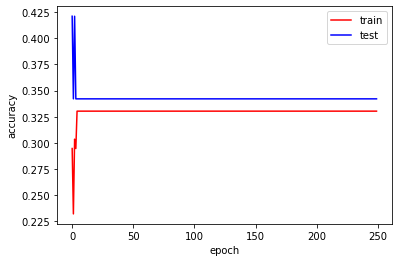

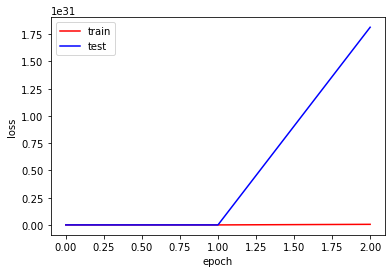

<Figure size 432x288 with 0 Axes>

In [13]:
learning_rate = 1

model = create_model() # We create the model
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model: define optimizer, loss and eventual metrics

model_history = model.fit(X_train,Y_train,
                          batch_size=16,
                          epochs=250,
                          validation_data=(X_test,Y_test))

print("Final train accuracy is: "+str(model_history.history["accuracy"][-1]))
print("Final test accuracy is: "+str(model_history.history["val_accuracy"][-1]))

plt.plot(t,model_history.history["accuracy"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_accuracy"],'b', label='test', linewidth=1.5)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

plt.plot(t,model_history.history["loss"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_loss"],'b', label='test', linewidth=1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

Le learning rate est trop élevé et l'optimisation est instable: il faut le diminuer.

Regardons maintenant l'architecture, essayons de réduire la taille de notre modèle en enlenvant la couche cachée:

Epoch 1/250
7/7 [==============================] - 0s 21ms/step - loss: 5.9820 - accuracy: 0.3164 - val_loss: 2.9746 - val_accuracy: 0.3421
Epoch 2/250
7/7 [==============================] - 0s 4ms/step - loss: 2.4002 - accuracy: 0.3374 - val_loss: 1.1203 - val_accuracy: 0.2105
Epoch 3/250
7/7 [==============================] - 0s 4ms/step - loss: 0.9787 - accuracy: 0.2871 - val_loss: 0.9848 - val_accuracy: 0.2632
Epoch 4/250
7/7 [==============================] - 0s 4ms/step - loss: 0.8670 - accuracy: 0.4231 - val_loss: 0.9588 - val_accuracy: 0.2632
Epoch 5/250
7/7 [==============================] - 0s 4ms/step - loss: 0.8501 - accuracy: 0.3882 - val_loss: 0.9284 - val_accuracy: 0.2632
Epoch 6/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8323 - accuracy: 0.4359 - val_loss: 0.8995 - val_accuracy: 0.2632
Epoch 7/250
7/7 [==============================] - 0s 4ms/step - loss: 0.7873 - accuracy: 0.4639 - val_loss: 0.8644 - val_accuracy: 0.3421
Epoch 8/250
7/7 [=========

7/7 [==============================] - 0s 5ms/step - loss: 0.4680 - accuracy: 0.9079 - val_loss: 0.5013 - val_accuracy: 0.7105
Epoch 60/250
7/7 [==============================] - 0s 4ms/step - loss: 0.4676 - accuracy: 0.8535 - val_loss: 0.4983 - val_accuracy: 0.7368
Epoch 61/250
7/7 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.8501 - val_loss: 0.4944 - val_accuracy: 0.7368
Epoch 62/250
7/7 [==============================] - 0s 5ms/step - loss: 0.4493 - accuracy: 0.8775 - val_loss: 0.4913 - val_accuracy: 0.7368
Epoch 63/250
7/7 [==============================] - 0s 5ms/step - loss: 0.4578 - accuracy: 0.8547 - val_loss: 0.4973 - val_accuracy: 0.7105
Epoch 64/250
7/7 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.8358 - val_loss: 0.4828 - val_accuracy: 0.7632
Epoch 65/250
7/7 [==============================] - 0s 4ms/step - loss: 0.4430 - accuracy: 0.9124 - val_loss: 0.4842 - val_accuracy: 0.7368
Epoch 66/250
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 0.3536 - accuracy: 0.9342 - val_loss: 0.4048 - val_accuracy: 0.9211
Epoch 118/250
7/7 [==============================] - 0s 5ms/step - loss: 0.3481 - accuracy: 0.9601 - val_loss: 0.4143 - val_accuracy: 0.8421
Epoch 119/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3544 - accuracy: 0.9543 - val_loss: 0.4077 - val_accuracy: 0.8684
Epoch 120/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3822 - accuracy: 0.9244 - val_loss: 0.4150 - val_accuracy: 0.8421
Epoch 121/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3935 - accuracy: 0.9526 - val_loss: 0.4252 - val_accuracy: 0.7368
Epoch 122/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3749 - accuracy: 0.9401 - val_loss: 0.4274 - val_accuracy: 0.7368
Epoch 123/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3549 - accuracy: 0.9527 - val_loss: 0.4040 - val_accuracy: 0.8684
Epoch 124/250
7/7 [========

7/7 [==============================] - 0s 4ms/step - loss: 0.3240 - accuracy: 0.9387 - val_loss: 0.3717 - val_accuracy: 0.8947
Epoch 176/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3472 - accuracy: 0.9218 - val_loss: 0.3703 - val_accuracy: 0.8947
Epoch 177/250
7/7 [==============================] - 0s 5ms/step - loss: 0.3321 - accuracy: 0.9517 - val_loss: 0.3608 - val_accuracy: 0.9211
Epoch 178/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3480 - accuracy: 0.9309 - val_loss: 0.3693 - val_accuracy: 0.8947
Epoch 179/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2890 - accuracy: 0.9539 - val_loss: 0.3663 - val_accuracy: 0.8947
Epoch 180/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3222 - accuracy: 0.9493 - val_loss: 0.3653 - val_accuracy: 0.9211
Epoch 181/250
7/7 [==============================] - 0s 4ms/step - loss: 0.3093 - accuracy: 0.9513 - val_loss: 0.3685 - val_accuracy: 0.8947
Epoch 182/250
7/7 [========

7/7 [==============================] - 0s 5ms/step - loss: 0.2727 - accuracy: 0.9645 - val_loss: 0.3256 - val_accuracy: 0.9474
Epoch 234/250
7/7 [==============================] - 0s 5ms/step - loss: 0.2896 - accuracy: 0.9697 - val_loss: 0.3395 - val_accuracy: 0.9211
Epoch 235/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2797 - accuracy: 0.9633 - val_loss: 0.3225 - val_accuracy: 0.9474
Epoch 236/250
7/7 [==============================] - 0s 5ms/step - loss: 0.2806 - accuracy: 0.9729 - val_loss: 0.3320 - val_accuracy: 0.9211
Epoch 237/250
7/7 [==============================] - 0s 5ms/step - loss: 0.2424 - accuracy: 0.9766 - val_loss: 0.3215 - val_accuracy: 0.9474
Epoch 238/250
7/7 [==============================] - 0s 4ms/step - loss: 0.2658 - accuracy: 0.9701 - val_loss: 0.3229 - val_accuracy: 0.9474
Epoch 239/250
7/7 [==============================] - 0s 5ms/step - loss: 0.2850 - accuracy: 0.9680 - val_loss: 0.3239 - val_accuracy: 0.9211
Epoch 240/250
7/7 [========

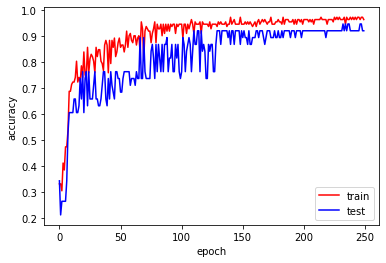

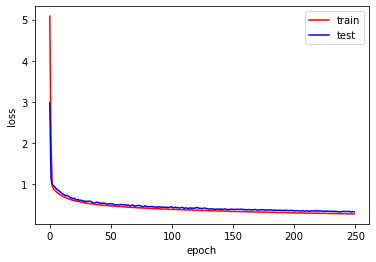

<Figure size 432x288 with 0 Axes>

In [14]:
def create_model():
    '''
    Create a fully connected neural network with one input layer and one output layer with softmax activation.
    '''
    input_layer = keras.layers.Input(shape=(4,)) # Input layer
    h = keras.layers.Dense(3, activation='softmax')(input_layer) # Output layer
    model = keras.models.Model(inputs=input_layer, outputs=h)
    return model

learning_rate = 1e-2

model = create_model() # We create the model
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model: define optimizer, loss and eventual metrics

model_history = model.fit(X_train,Y_train,
                          batch_size=16,
                          epochs=250,
                          validation_data=(X_test,Y_test))

print("Final train accuracy is: "+str(model_history.history["accuracy"][-1]))
print("Final test accuracy is: "+str(model_history.history["val_accuracy"][-1]))

plt.plot(t,model_history.history["accuracy"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_accuracy"],'b', label='test', linewidth=1.5)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

plt.plot(t,model_history.history["loss"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_loss"],'b', label='test', linewidth=1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

Le modèle performe de façon correcte, mais imparfaite. Il manque de paramètres pour mieux décrire le jeu de données ("underfitting"). Comme on utilise un jeu de données très simple, un modèle plus simple arrive à se débrouiller, mais dans un cas plus concret il faudrait essayer d'ajouter plus de complexité. Essayons le contraire: ajoutons plus de couches et de neurones.

Epoch 1/250
7/7 [==============================] - 0s 21ms/step - loss: 1.9281 - accuracy: 0.3150 - val_loss: 0.8211 - val_accuracy: 0.7632
Epoch 2/250
7/7 [==============================] - 0s 5ms/step - loss: 0.8726 - accuracy: 0.5751 - val_loss: 0.6585 - val_accuracy: 0.6316
Epoch 3/250
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.7157 - val_loss: 0.7036 - val_accuracy: 0.7632
Epoch 4/250
7/7 [==============================] - 0s 5ms/step - loss: 0.6788 - accuracy: 0.7398 - val_loss: 1.1592 - val_accuracy: 0.5789
Epoch 5/250
7/7 [==============================] - 0s 5ms/step - loss: 0.6253 - accuracy: 0.8245 - val_loss: 1.0834 - val_accuracy: 0.5789
Epoch 6/250
7/7 [==============================] - 0s 5ms/step - loss: 0.4945 - accuracy: 0.7993 - val_loss: 0.4569 - val_accuracy: 0.9211
Epoch 7/250
7/7 [==============================] - 0s 5ms/step - loss: 0.4650 - accuracy: 0.8665 - val_loss: 0.5474 - val_accuracy: 0.6053
Epoch 8/250
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 0.0895 - accuracy: 0.9868 - val_loss: 0.1286 - val_accuracy: 0.9474
Epoch 60/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1139 - accuracy: 0.9791 - val_loss: 0.1314 - val_accuracy: 0.9737
Epoch 61/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1409 - accuracy: 0.9672 - val_loss: 0.1187 - val_accuracy: 0.9737
Epoch 62/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1057 - accuracy: 0.9657 - val_loss: 0.1443 - val_accuracy: 0.9474
Epoch 63/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1307 - accuracy: 0.9301 - val_loss: 0.1346 - val_accuracy: 0.9737
Epoch 64/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0928 - accuracy: 0.9930 - val_loss: 0.1163 - val_accuracy: 0.9737
Epoch 65/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1285 - accuracy: 0.9562 - val_loss: 0.1215 - val_accuracy: 0.9737
Epoch 66/250
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 0.2637 - accuracy: 0.8898 - val_loss: 0.1041 - val_accuracy: 0.9737
Epoch 118/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1578 - accuracy: 0.9558 - val_loss: 0.0934 - val_accuracy: 0.9474
Epoch 119/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0888 - accuracy: 0.9680 - val_loss: 0.1259 - val_accuracy: 0.9474
Epoch 120/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1339 - accuracy: 0.9568 - val_loss: 0.0887 - val_accuracy: 0.9737
Epoch 121/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0594 - accuracy: 0.9872 - val_loss: 0.0844 - val_accuracy: 0.9737
Epoch 122/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1293 - accuracy: 0.9588 - val_loss: 0.1795 - val_accuracy: 0.9211
Epoch 123/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1032 - accuracy: 0.9718 - val_loss: 0.1281 - val_accuracy: 0.9474
Epoch 124/250
7/7 [========

7/7 [==============================] - 0s 4ms/step - loss: 0.1014 - accuracy: 0.9575 - val_loss: 0.1144 - val_accuracy: 0.9474
Epoch 176/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1174 - accuracy: 0.9580 - val_loss: 0.1215 - val_accuracy: 0.9474
Epoch 177/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9632 - val_loss: 0.0840 - val_accuracy: 0.9737
Epoch 178/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0901 - accuracy: 0.9768 - val_loss: 0.1235 - val_accuracy: 0.9474
Epoch 179/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.9712 - val_loss: 0.0910 - val_accuracy: 0.9474
Epoch 180/250
7/7 [==============================] - 0s 5ms/step - loss: 0.1338 - accuracy: 0.9406 - val_loss: 0.0964 - val_accuracy: 0.9737
Epoch 181/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1034 - accuracy: 0.9396 - val_loss: 0.0700 - val_accuracy: 1.0000
Epoch 182/250
7/7 [========

7/7 [==============================] - 0s 4ms/step - loss: 0.0808 - accuracy: 0.9798 - val_loss: 0.0647 - val_accuracy: 1.0000
Epoch 234/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0727 - accuracy: 0.9541 - val_loss: 0.1189 - val_accuracy: 0.9474
Epoch 235/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1076 - accuracy: 0.9665 - val_loss: 0.1064 - val_accuracy: 0.9474
Epoch 236/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.9782 - val_loss: 0.0885 - val_accuracy: 0.9737
Epoch 237/250
7/7 [==============================] - 0s 4ms/step - loss: 0.1490 - accuracy: 0.9571 - val_loss: 0.0654 - val_accuracy: 0.9737
Epoch 238/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 0.9667 - val_loss: 0.0683 - val_accuracy: 0.9737
Epoch 239/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.9856 - val_loss: 0.0904 - val_accuracy: 0.9737
Epoch 240/250
7/7 [========

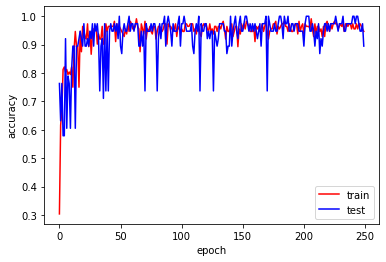

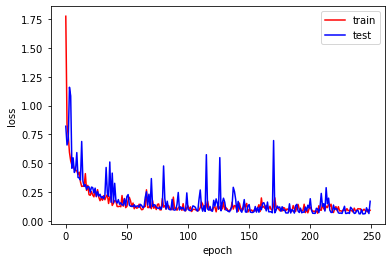

<Figure size 432x288 with 0 Axes>

In [15]:
def create_model():
    '''
    Create a fully connected neural network with one input layer and one output layer with softmax activation.
    '''
    input_layer = keras.layers.Input(shape=(4,)) # Input layer
    h = keras.layers.Dense(128)(input_layer) # Hidden layer
    h = keras.layers.Dense(128)(h) # Hidden layer
    h = keras.layers.Dense(128)(h) # Hidden layer
    h = keras.layers.Dense(3, activation='softmax')(h) # Output layer
    model = keras.models.Model(inputs=input_layer, outputs=h)
    return model

learning_rate = 1e-2

model = create_model() # We create the model
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model: define optimizer, loss and eventual metrics

model_history = model.fit(X_train,Y_train,
                          batch_size=16,
                          epochs=250,
                          validation_data=(X_test,Y_test))

print("Final train accuracy is: "+str(model_history.history["accuracy"][-1]))
print("Final test accuracy is: "+str(model_history.history["val_accuracy"][-1]))

plt.plot(t,model_history.history["accuracy"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_accuracy"],'b', label='test', linewidth=1.5)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

plt.plot(t,model_history.history["loss"],'r', label='train', linewidth=1.5)
plt.plot(t,model_history.history["val_loss"],'b', label='test', linewidth=1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.clf()

Avec plus de couches, on converge plus vite mais on perd en stabilité, notamment sur le jeu de test: on a une loss et une précision très instable. En fait, lorsqu'on rajoute plus de paramètres, on court le risque "d'overfitting": le réseau apprend "trop" sur le jeu d'entraînement et perd en capacité de généralisation. Encore une fois, sur un jeu de données simple comme Iris, cela n'est pas très flagrant, mais sur un jeu de données plus complexe cela peut se voir par un écart bien notable entre entraînement et test. 

Un autre problème d'ajouter des couches est la "disparition du gradient" ("vanishing gradient" en anglais). En effet, les valeurs des dérivées partielles successives dans l'algorithme de rétropropagation peuvent diminuer de plus en plus au fil des couches, notamment si le réseau comporte beaucoup de couches avec des activations. Cela veut dire que des poids vont être très peu voire pas mis à jour lors des différentes itérations de l'algorithme. Nous n'allons cependant pas nous intéresser plus à ce phénomène ici.

En résumé, lorsque vous allez vous attaquer à un problème de machine learning et que vous envisagez d'utiliser un réseau de neurones, sachez qu'il n'existe pas de réseau "parfait", il va falloir tester différentes architectures et paramètres à chaque fois, en plus de l'importance du prétraitement des données. C'est pourquoi il est très important de comprendre la signification de chaque paramètre et de son éventuelle influence sur la performance de votre modèle, afin de savoir quelles modifications appliquer pour obtenir les meilleurs résultats possibles. Pour ne pas être submergés, commencez par le modèle le plus simple et petit possible, et ajoutez petit à petit de la complexité pour voir comment évolue vos résultats: ajoutez une couche, augmentez le nombre de neurones, ajustez le learning rate ou le nombre d'époques, etc...

# Pour aller plus loin...

Si vous êtes arrivés jusqu'ici, vous pouvez essayer de jouer sur plus de paramètres ! Ajoutez ou supprimez des couches ou des neurones, changez le nombre d'époques, etc... et regardez les résultats.

Une fois que vous avez fait le tour du dataset iris, essayez de résoudre le problème suivant: scikit-learn possède un autre dataset, digits, qui comprend des images de résolution 8x8 pixels en noir et blanc représentant des chiffres de 0 à 9. Le but est de définir et d'entraîner un réseau pour prédire correctement les chiffres à partir des images. Pour charger le dataset digits, écrivez cette ligne de code:

In [16]:
digits = datasets.load_digits()

Encore une fois, après avoir obtenu des résultats, n'hésitez pas à jouer sur les paramètres à votre disposition pour modifier l'expérience et essayer d'avoir de meilleurs résultats.